In [236]:
#import all required packages
import os
import numpy as np
import matplotlib.pyplot as plt

from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.visualization import SqrtStretch, simple_norm
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.io import fits,ascii
from astropy.wcs import WCS
from astropy import units as u
from astropy.stats import sigma_clipped_stats
from astropy.table import join

from photutils.aperture import SkyCircularAperture,SkyCircularAnnulus,aperture_photometry 
from photutils.segmentation import detect_threshold, detect_sources, deblend_sources, SourceCatalog
from photutils.background import Background2D, MedianBackground
from photutils.utils import calc_total_error

In [237]:
#data path
dpath='E:\Documents\SofiaLegacyProgram\CAL_files\CAL_R'
#dpath='C:/Users/mhankins1/Documents/SofiaLegacyProgram/SOFIA_Cycle7_Data/SgrCandNearby'

#file name
fname='F0592_FO_IMA_0701892_FORF253_CAL_0120-0141_FIELD_2.fits'

#Name of field
field='Field2'

#wavelength of data
wavelength=25.2

In [238]:
#change directory to data location
os.chdir(dpath)

#import data - unpack fits file into header, image (data), varance (varmap), and exposure time (tmap)
hdu=fits.open(fname)
header=hdu[0].header
ims=hdu[0].data
#np.shape(ims)
data=ims[0]
varmap=ims[1]
tmap=ims[2]
#wcsmap = WCS(header)
hdu.close()

#hack to make SOFIA wcs header work correctly with astropy.wcs
hdu[0].header['NAXIS']=2
wcsmap=WCS(hdu[0].header)

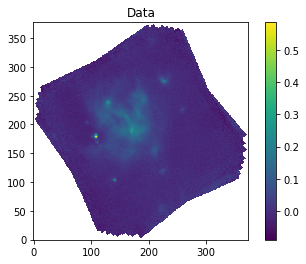

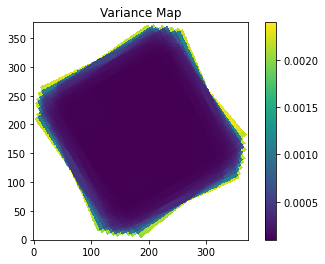

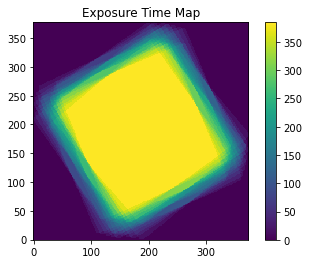

In [239]:
#take a quick look at the maps that were loaded in 
plt.figure()
plt.title('Data')
plt.imshow(data,origin='lower',interpolation='none')
plt.colorbar()
#plt.clim(0.0,0.1)
plt.show()

plt.figure()
plt.title('Variance Map')
plt.imshow(varmap,origin='lower',interpolation='none')
plt.colorbar()
plt.show()

plt.figure()
plt.title('Exposure Time Map')
plt.imshow(tmap,origin='lower',interpolation='none')
plt.colorbar()
plt.show()

#create pixel error map by taking sqrt of variance map
errormap=np.sqrt(varmap)

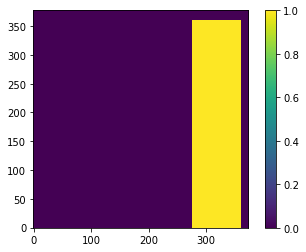

In [240]:
#create mask for edges of field where less integration time was collected
tmapnorm=tmap/np.max(tmap) #normalize the exposure time map
mask=np.where(tmapnorm<0.3,tmapnorm,0).astype('bool') #create mask for any locations with less than 50% of max exposure time -Can be modified as needed
#the above can be adjusted if there are obvious sources near the edges of the map

#additional series of masks that can be applied when searching for sources in the segmentation map
mask2=np.zeros(np.shape(mask))  #mask 2 is applied to the first segmentation map instance for source detection
mask2[0:360,275:360]=1
mask3=np.zeros(np.shape(mask))  #mask 3 is applied to the deblended segmentation map for source detection - this may or may not be needed if the first 2 masks work ok
#mask3[0:330,0:70]=1

#plot any of the masks to verify they are configured as needed
plt.figure()
plt.imshow(mask2,origin='lower',interpolation='none')
plt.colorbar()
plt.show()

In [270]:
#create background model for image using median method
bkg_estimator = MedianBackground()
bkg_data = Background2D(data,(16, 16), filter_size=(3, 3),bkg_estimator=bkg_estimator,edge_method='pad') #smaller box?, 20x20, 25x25?
bkg_rms=bkg_data.background_rms
bkg=bkg_data.background 

#create background subtracted image
data_bkgsub = data - bkg

#set detection threshold for source finding based on modeled background rms
threshold = 3.0*bkg_rms

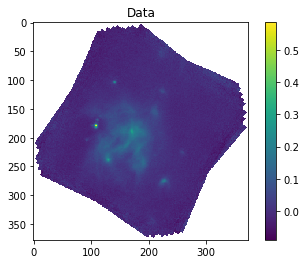

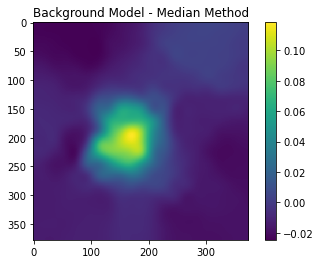

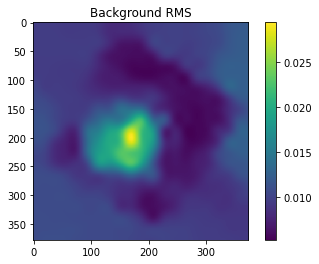

In [242]:
#take a look at data and bakground model images
plt.figure()
plt.title('Data')
plt.imshow(data,interpolation='none')
plt.colorbar()
plt.show()

plt.figure()
plt.title('Background Model - Median Method')
plt.imshow(bkg,interpolation='none')
plt.colorbar()
plt.show()

plt.figure()
plt.title('Background RMS')
plt.imshow(bkg_rms,interpolation='none')
plt.colorbar()
plt.show()

In [243]:
#do source detection. A 3x3 FWHM gaussian is used to smooth image prior to detection
sigma = 3.0 * gaussian_fwhm_to_sigma  # FWHM = 3.
kernel = Gaussian2DKernel(sigma, x_size=3, y_size=3)
kernel.normalize()
segm = detect_sources(data_bkgsub, threshold, mask=mask, npixels=5, filter_kernel=kernel)

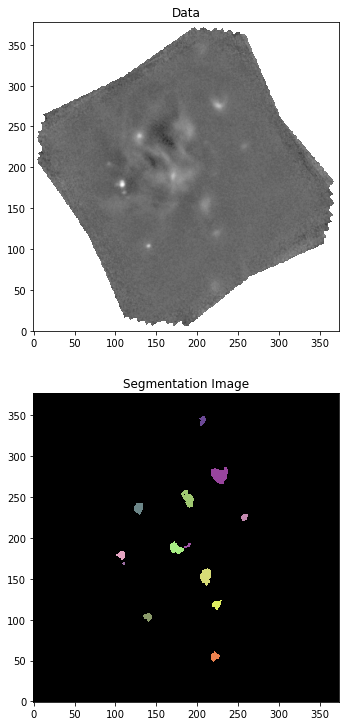

In [244]:
#removed labels that exist in masked region (mask2)
segm.remove_masked_labels(mask2.astype('bool'))

#make plot of segmentation image to show detected sources
norm = ImageNormalize(stretch=SqrtStretch())
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))
ax1.imshow(data_bkgsub, origin='lower', cmap='Greys_r', norm=norm)
ax1.set_title('Data')
cmap = segm.make_cmap(seed=123)
ax2.imshow(segm, origin='lower', cmap=cmap, interpolation='nearest')
ax2.set_title('Segmentation Image')
plt.show()

In [245]:
#now lets look at building a catalog and associated table from the seg map
cat = SourceCatalog(data_bkgsub, segm,background=bkg,wcs=wcsmap) #can also take in error and bkg measurements - this is done later

#specify the columns that we want for our table
columns=['label','xcentroid','ycentroid','sky_centroid','background_centroid', 'background_mean','background_sum','area',
         'semimajor_sigma','semiminor_sigma','orientation', 'cxx','cxy','cyy','eccentricity','ellipticity','elongation',
         'fwhm','kron_flux','kron_fluxerr','kron_radius','segment_flux','segment_fluxerr']

#create table
tbl = cat.to_table(columns)

#display table below
tbl

label,xcentroid,ycentroid,sky_centroid,background_centroid,background_mean,background_sum,area,semimajor_sigma,semiminor_sigma,orientation,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr
,,,"deg,deg",,,,pix2,pix,pix,deg,1 / pix2,1 / pix2,1 / pix2,,,,pix,,,pix,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,221.6165509442812,54.93673427647289,"266.13978020429977,-29.497235056387865",-0.018137281707807006,-0.0030242428105773313,-0.26613336733080517,88.0,2.904774948891367,2.345999014268467,70.39949720347359,0.17458570794927664,-0.03993254084777956,0.12562532992401015,0.589682199130736,0.19236462185690562,1.2381825104036281,6.217221926300213,12.956505038381742,nan,3.0208522911502214,3.3116104391077914,nan
2,140.39632877627477,103.5690573387696,"266.15968607285254,-29.48685944010572",0.0066686772283519906,-0.006928078447392761,-0.5473181973440281,79.0,2.033049833925688,1.9190565861479376,-38.5706838284798,0.2534427681408011,0.02885400318712459,0.26002929526072316,0.33014585933359075,0.05607007062765257,1.0594006704130416,4.655184958954311,6.9389817044592474,nan,2.0965554898477974,4.956756218359404,nan
3,224.12542347564218,119.09459214217581,"266.13916604130884,-29.483548024257136",0.07771152310059598,0.00017051130418118597,0.015516528680487923,91.0,2.884835816316731,2.182639398499454,36.07307174091866,0.15127686798321077,-0.08542967482519895,0.17879394200558069,0.6538889827557146,0.24340949105166743,1.321718932728893,6.023506416632345,6.294265529533203,nan,2.260977053376203,3.4995267448876652,nan
4,210.44909590865583,153.51238027920292,"266.14251787942567,-29.476205664300405",0.1032625356682866,0.017925844913599897,3.674798207287979,205.0,4.748076142490703,3.022208577135576,82.5853786863878,0.10839952620141942,-0.016668516257515746,0.0454418476548049,0.7712666007327071,0.3634877608449192,1.5710616991865234,9.371765425248132,12.76005768461836,nan,1.0695171392793312,10.292283620754885,nan
5,110.78776697200902,168.97998378306363,"266.1669394638323,-29.47290411044649",-0.004052807763234469,0.017357564002078007,0.17357564002078008,10.0,0.9322970533754106,0.7351202223416197,0.7199111036686405,1.1506230940723976,-0.017587954818225015,1.8503646618770933,0.6150292603430693,0.21149571407515022,1.2682239245244982,1.976912827482281,0.7863907595715586,nan,0.9946625975242748,0.6825033348818498,nan
6,108.21842570718123,179.27225181737438,"266.1675685765994,-29.47070832144944",-0.004894298400921481,0.006662991155001952,0.5530282658651621,83.0,2.095713545982172,1.9377189448259458,-86.46932923180479,0.2661824304179226,0.004750466273187637,0.2278324634055636,0.38091370549281084,0.07538940684862572,1.0815363866767675,4.752645848156806,3.373754139124704,nan,0.30251263636349174,14.161743416531367,nan
7,173.96275229186708,187.70858768853665,"266.15145849237945,-29.46891033238774",0.07344226217803312,0.10782384701799218,17.467463216914734,162.0,4.4284177521464425,2.959883298267229,-35.06677130004089,0.07183742442001984,0.05939300320608886,0.09329807306775441,0.7438164496879488,0.33161606155323053,1.496146065873246,8.869234076221542,68.61781595148088,nan,3.185574715260849,16.504009538159764,nan
8,188.86653695006615,191.07985433399,"266.1478065178654,-29.46819125862828",0.08627036748258676,0.09198539513056685,2.207649483133604,24.0,2.7962486625581184,0.9300302001066173,31.83672813673777,0.41400668185083234,-0.9215870793074781,0.870014744614887,0.943068258808721,0.6674007528158139,3.006621357282334,4.906837800615415,23.89004314181672,nan,3.656865436293138,1.6624354135500885,nan


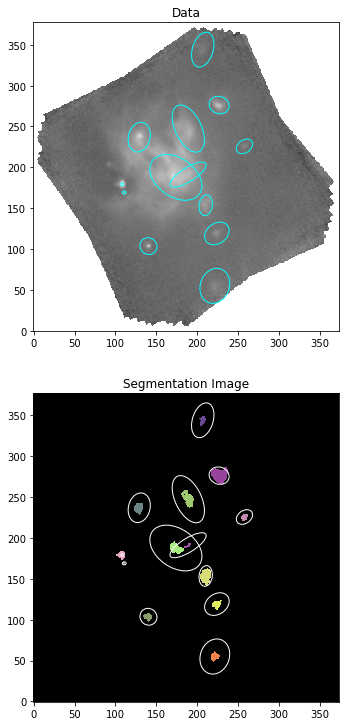

In [246]:
#overplot catalog sources on image - Note some sources may not have apertures plotted if kron aperture fails, but that's ok
norm = simple_norm(data, 'sqrt')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))
ax1.imshow(data, origin='lower', cmap='Greys_r', norm=norm)
ax1.set_title('Data')
cmap = segm.make_cmap(seed=123)
ax2.imshow(segm, origin='lower', cmap=cmap,interpolation='nearest')
ax2.set_title('Segmentation Image')
#try-except logic to catch any instances where kron aperture does something weird
for aperture in cat.kron_aperture:
    try:
        aperture.plot(axes=ax1, color='cyan', lw=1.)
        aperture.plot(axes=ax2, color='white', lw=1.)
    except:
        skip=1
plt.show()

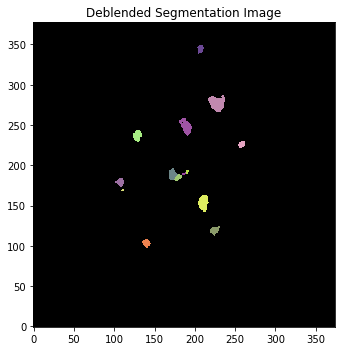

In [247]:
#lets take a look at deblending sources
segm_deblend = deblend_sources(data_bkgsub, segm, npixels=5,filter_kernel=kernel, nlevels=64,contrast=0.001)

#remove any sources that should be masked (mask3)
segm_deblend.remove_masked_labels(mask3.astype('bool'))

#plot the deblended image
plt.figure(figsize=(5.4, 8.5))
plt.imshow(segm_deblend, origin='lower', cmap=cmap, interpolation='nearest')
plt.title('Deblended Segmentation Image')
plt.show()

In [248]:
#now lets look at building a catalog and table from the deblended seg map
catde = SourceCatalog(data_bkgsub, segm_deblend,background=bkg,wcs=wcsmap)

#define which columns we want to have in the table
columns=['label','xcentroid','ycentroid','sky_centroid','background_centroid', 'background_mean','background_sum','area',
         'semimajor_sigma','semiminor_sigma','orientation', 'cxx','cxy','cyy','eccentricity','ellipticity','elongation',
         'fwhm','kron_flux','kron_fluxerr','kron_radius','segment_flux','segment_fluxerr']

#create table
tbl_deblend = catde.to_table(columns)

#display table
tbl_deblend

label,xcentroid,ycentroid,sky_centroid,background_centroid,background_mean,background_sum,area,semimajor_sigma,semiminor_sigma,orientation,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr
,,,"deg,deg",,,,pix2,pix,pix,deg,1 / pix2,1 / pix2,1 / pix2,,,,pix,,,pix,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,221.6165509442812,54.93673427647289,"266.13978020429977,-29.497235056387865",-0.018137281707807006,-0.0030242428105773313,-0.26613336733080517,88.0,2.904774948891367,2.345999014268467,70.39949720347359,0.17458570794927664,-0.03993254084777956,0.12562532992401015,0.589682199130736,0.19236462185690562,1.2381825104036281,6.217221926300213,12.956505038381742,nan,3.0208522911502214,3.3116104391077914,nan
2,140.39632877627477,103.5690573387696,"266.15968607285254,-29.48685944010572",0.0066686772283519906,-0.006928078447392761,-0.5473181973440281,79.0,2.033049833925688,1.9190565861479376,-38.5706838284798,0.2534427681408011,0.02885400318712459,0.26002929526072316,0.33014585933359075,0.05607007062765257,1.0594006704130416,4.655184958954311,6.9389817044592474,nan,2.0965554898477974,4.956756218359404,nan
3,224.12542347564218,119.09459214217581,"266.13916604130884,-29.483548024257136",0.07771152310059598,0.00017051130418118597,0.015516528680487923,91.0,2.884835816316731,2.182639398499454,36.07307174091866,0.15127686798321077,-0.08542967482519895,0.17879394200558069,0.6538889827557146,0.24340949105166743,1.321718932728893,6.023506416632345,6.294265529533203,nan,2.260977053376203,3.4995267448876652,nan
4,210.44909590865583,153.51238027920292,"266.14251787942567,-29.476205664300405",0.1032625356682866,0.017925844913599897,3.674798207287979,205.0,4.748076142490703,3.022208577135576,82.5853786863878,0.10839952620141942,-0.016668516257515746,0.0454418476548049,0.7712666007327071,0.3634877608449192,1.5710616991865234,9.371765425248132,12.76005768461836,nan,1.0695171392793312,10.292283620754885,nan
5,110.78776697200902,168.97998378306363,"266.1669394638323,-29.47290411044649",-0.004052807763234469,0.017357564002078007,0.17357564002078008,10.0,0.9322970533754106,0.7351202223416197,0.7199111036686405,1.1506230940723976,-0.017587954818225015,1.8503646618770933,0.6150292603430693,0.21149571407515022,1.2682239245244982,1.976912827482281,0.7863907595715586,nan,0.9946625975242748,0.6825033348818498,nan
6,108.21842570718123,179.27225181737438,"266.1675685765994,-29.47070832144944",-0.004894298400921481,0.006662991155001952,0.5530282658651621,83.0,2.095713545982172,1.9377189448259458,-86.46932923180479,0.2661824304179226,0.004750466273187637,0.2278324634055636,0.38091370549281084,0.07538940684862572,1.0815363866767675,4.752645848156806,3.373754139124704,nan,0.30251263636349174,14.161743416531367,nan
7,257.91067631740754,225.64826742759263,"266.13088940205085,-29.460815964580334",0.005984946278867195,-0.007267197299337207,-0.4142302460622208,57.0,2.2938184853811086,1.6479124251284551,35.78140252111615,0.25097164083141665,-0.16903847203837633,0.307325161298202,0.6956152874969825,0.28158551531828757,1.3919541174661056,4.7029295485286,3.171440903908861,nan,1.897223652353929,1.8581919381048697,nan
8,129.11526870032176,236.99936361757509,"266.1624458880217,-29.45839397536969",-0.00024386975475125132,0.060630954909383646,7.336345544035421,121.0,3.3006460196269956,2.373304351678524,76.15194554231044,0.1726264970543116,-0.03985380177136669,0.09670366333653235,0.6949662319310287,0.28095762539639735,1.3907386203091092,6.769204074388868,22.165248790820534,nan,2.227908123122104,12.310539411430373,nan


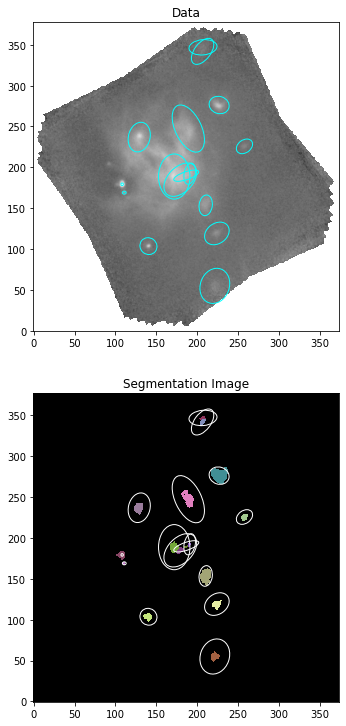

In [249]:
#overplot catalog sources on image - Note some sources may not have apertures plotted if kron aperture fails, but that's ok
norm = simple_norm(data, 'sqrt')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))
ax1.imshow(data, origin='lower', cmap='Greys_r', norm=norm)
ax1.set_title('Data')
cmap = segm_deblend.make_cmap(seed=123)
ax2.imshow(segm_deblend, origin='lower', cmap=cmap,interpolation='nearest')
ax2.set_title('Segmentation Image')
#try-except logic to catch any instances where kron aperture does something weird
for aperture in catde.kron_aperture:
    try:
        aperture.plot(axes=ax1, color='cyan', lw=1.)
        aperture.plot(axes=ax2, color='white', lw=1.)
    except:
        skip=1
plt.show()

In [250]:
#what if we wanted to include errors? - Not completely sure this is implemented correctly for our observations, but we'll use it for now...
calfactor = header['CALFCTR'] # units are (Me/sec/Jy)
gainfactor=tmap*calfactor*1e6 #gain in electrons/Jy
#errormap=calc_total_error(data,bkg,gainfactor) #use the varmap instead. Its probably more appropriate for our data type. 

#now lets look at building a catalog from the seg map
catwerr = SourceCatalog(data_bkgsub, segm_deblend,background=bkg,error=errormap,wcs=wcsmap)
columns=['label','xcentroid','ycentroid','sky_centroid','background_centroid', 'background_mean','background_sum','background','area',
         'semimajor_sigma','semiminor_sigma','orientation', 'cxx','cxy','cyy','eccentricity','ellipticity','elongation',
         'fwhm','kron_flux','kron_fluxerr','kron_radius','segment_flux','segment_fluxerr']#,'kron_aperture']
tbl2 = catwerr.to_table(columns)

In [251]:
#calculate statistics for background cutouts in table
segbkg_median=[]
segbkg_mean=[]
segbkg_std=[]

#loop through each cutout and use sigma_cliped_stats to get mean, median, and std
for i in range (0,len(tbl2['background'])):
    bkgdata=tbl2['background'][i]
    meansc, median_sigclip, stdsc = sigma_clipped_stats(bkgdata)
    segbkg_median.append(median_sigclip)
    segbkg_mean.append(meansc)
    segbkg_std.append(stdsc)

#add the above calculated information to our table
tbl2['segbkg_mean_sc']=segbkg_mean
tbl2['segbkg_median_sc']=segbkg_median
tbl2['segbkg_std_sc']=segbkg_std  

#remove the 2d background array to tidy up the table
tbl2.remove_column('background')

In [252]:
#calculate noise stats
#sky noise from background
skynoise=np.sqrt(tbl2['segbkg_median_sc']*tbl2['area']/u.pix**2)
#replace any nan values with zero
sna=np.array(skynoise)
masknan=np.isnan(sna)
sna[masknan]=0.0
skynoise=sna**2

#shot noise from the source
sourcenoise=tbl2['segment_flux']

#thermal noise from camera (from error map)
thermalnoise=tbl2['segment_fluxerr']

#total noise
#totalnoise=np.sqrt(sourcenoise+thermalnoise+skynoise) #includes all noise sources
totalnoise=np.sqrt(thermalnoise+skynoise) #no shot noise -> For some reason this seems to work much better for the apertures. Need to think about why this is a bit more...

#calculate SNR for the segments
tbl2['segmentSNR']=tbl2['segment_flux']/ totalnoise 

#display table
tbl2

E:\Software\anaconda3\lib\site-packages\astropy\units\quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


label,xcentroid,ycentroid,sky_centroid,background_centroid,background_mean,background_sum,area,semimajor_sigma,semiminor_sigma,orientation,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr,segbkg_mean_sc,segbkg_median_sc,segbkg_std_sc,segmentSNR
,,,"deg,deg",,,,pix2,pix,pix,deg,1 / pix2,1 / pix2,1 / pix2,,,,pix,,,pix,,,,,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64
1,221.6165509442812,54.93673427647289,"266.13978020429977,-29.497235056387865",-0.018137281707807006,-0.0030242428105773313,-0.26613336733080517,88.0,2.904774948891367,2.345999014268467,70.39949720347359,0.17458570794927664,-0.03993254084777956,0.12562532992401015,0.589682199130736,0.19236462185690562,1.2381825104036281,6.217221926300213,12.956505038381742,0.7600847407661554,3.0208522911502214,3.3116104391077914,0.1631745,-0.002875852051494358,-0.003017922672943979,0.000985570327143869,8.198097973428014
2,140.39632877627477,103.5690573387696,"266.15968607285254,-29.48685944010572",0.0066686772283519906,-0.006928078447392761,-0.5473181973440281,79.0,2.033049833925688,1.9190565861479376,-38.5706838284798,0.2534427681408011,0.02885400318712459,0.26002929526072316,0.33014585933359075,0.05607007062765257,1.0594006704130416,4.655184958954311,6.9389817044592474,0.18780157774286113,2.0965554898477974,4.956756218359404,0.09096325,-0.007140446756318711,-0.007223267204584543,0.0013142718216045581,16.434805594075648
3,224.12542347564218,119.09459214217581,"266.13916604130884,-29.483548024257136",0.07771152310059598,0.00017051130418118597,0.015516528680487923,91.0,2.884835816316731,2.182639398499454,36.07307174091866,0.15127686798321077,-0.08542967482519895,0.17879394200558069,0.6538889827557146,0.24340949105166743,1.321718932728893,6.023506416632345,6.294265529533203,0.25694853651533134,2.260977053376203,3.4995267448876652,0.09742679,-3.671359754506809e-05,-0.00020849505859099163,0.0019709614166440203,11.211665360576927
4,210.44909590865583,153.51238027920292,"266.14251787942567,-29.476205664300405",0.1032625356682866,0.017925844913599897,3.674798207287979,205.0,4.748076142490703,3.022208577135576,82.5853786863878,0.10839952620141942,-0.016668516257515746,0.0454418476548049,0.7712666007327071,0.3634877608449192,1.5710616991865234,9.371765425248132,12.76005768461836,0.180617739162465,1.0695171392793312,10.292283620754885,0.14405362,0.01805207705283846,0.016007666452677392,0.007624981409458308,5.5608581903938346
5,110.78776697200902,168.97998378306363,"266.1669394638323,-29.47290411044649",-0.004052807763234469,0.017357564002078007,0.17357564002078008,10.0,0.9322970533754106,0.7351202223416197,0.7199111036686405,1.1506230940723976,-0.017587954818225015,1.8503646618770933,0.6150292603430693,0.21149571407515022,1.2682239245244982,1.976912827482281,0.7863907595715586,0.03730829084599064,0.9946625975242748,0.6825033348818498,0.03234266,0.016797227443490336,0.016783451918504264,0.0021418640444225675,1.5254483025627135
6,108.21842570718123,179.27225181737438,"266.1675685765994,-29.47070832144944",-0.004894298400921481,0.006662991155001952,0.5530282658651621,83.0,2.095713545982172,1.9377189448259458,-86.46932923180479,0.2661824304179226,0.004750466273187637,0.2278324634055636,0.38091370549281084,0.07538940684862572,1.0815363866767675,4.752645848156806,3.373754139124704,0.027723301717186247,0.30251263636349174,14.161743416531367,0.09354798,0.005929543287540419,0.005322041561770044,0.005426597637181361,19.35651894018077
7,257.91067631740754,225.64826742759263,"266.13088940205085,-29.460815964580334",0.005984946278867195,-0.007267197299337207,-0.4142302460622208,57.0,2.2938184853811086,1.6479124251284551,35.78140252111615,0.25097164083141665,-0.16903847203837633,0.307325161298202,0.6956152874969825,0.28158551531828757,1.3919541174661056,4.7029295485286,3.17

In [253]:
#now lets look at performing some aperture photometry on the data.... Lets get the source centroids from the segmentaion map table
sourcecoords=tbl2['sky_centroid']

In [254]:
#first let's do some simple annulus extractions...   
radii = [2,4,6,8,10] #define aperture radii & construct apertures (line below)
apertures =[SkyCircularAperture(sourcecoords, r=r*u.arcsec) for r in radii] # for pixels: r=r*u.arcsec*0.786

#do aperture photometry on data using defined apertures 
phot_table = aperture_photometry(data_bkgsub, apertures,wcs=wcsmap,error=errormap,method='exact')

#display phot table
phot_table

id,xcenter,ycenter,sky_center,aperture_sum_0,aperture_sum_err_0,aperture_sum_1,aperture_sum_err_1,aperture_sum_2,aperture_sum_err_2,aperture_sum_3,aperture_sum_err_3,aperture_sum_4,aperture_sum_err_4
,pix,pix,"deg,deg",,,,,,,,,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,221.6165509442321,54.936734276325524,"266.13978020429977,-29.497235056387865",0.8545315994809511,0.08253965426531067,3.1783921954499257,0.1604363051243773,5.431690665938099,0.23724483785345124,7.464944052518822,0.31998547845130265,9.165760657321208,0.412625403320962
2,140.39632877635597,103.56905733876239,"266.15968607285254,-29.48685944010572",2.814625243623711,0.04725918661190095,4.993895880050231,0.09448086648647637,6.197913980114574,0.14170854514251846,6.9668797023233475,0.18895276403955943,7.306553554307429,0.236162739603919
3,224.12542347557059,119.09459214212097,"266.13916604130884,-29.483548024257136",1.186000167650302,0.04712321423329318,3.266922400123304,0.09428768369159893,4.592690219246912,0.14147678643516473,5.508891249404929,0.18867388616109898,6.113071105211929,0.23584352184067506
4,210.44909590871453,153.5123802791827,"266.14251787942567,-29.476205664300405",1.5351724438609047,0.04639509852769502,5.297849822427575,0.09281035083386699,9.44150690321998,0.13927567282333397,12.483310677748268,0.18572013902536327,14.30859221816454,0.2321871167503743
5,110.78776697204559,168.97998378308105,"266.1669394638323,-29.47290411044649",0.9943414469657267,0.04717892337239518,0.9727049887600013,0.09436455473820557,1.4751725378234843,0.1415682201035204,6.728590296168925,0.18870972935666225,12.043708902825855,0.2358884548944862
6,108.21842570704759,179.27225181735713,"266.1675685765994,-29.47070832144944",7.688102888010407,0.04738276941122781,13.933625450970764,0.09476429509456633,14.722418939722656,0.14210675416717708,13.51541448122844,0.18946335115913035,11.170562453738507,0.23676824263317758
7,257.91067631729044,225.64826742758126,"266.13088940205085,-29.460815964580334",0.9296702269735051,0.04752196159311097,2.2302546401698335,0.09502283304581531,3.072444432883658,0.14254687632845917,3.2373115210335306,0.19002355734272172,2.9685328164725995,0.2374705034445785
8,129.11526870018383,236.99936361760746,"266.1624458880217,-29.45839397536969",3.621003956416914,0.04734377402384678,9.793033742409216,0.09468949295583357,15.257543276975493,0.14207983498659413,19.04857945854328,0.18942236648403657,20.987038393031927,0.23677331148571304


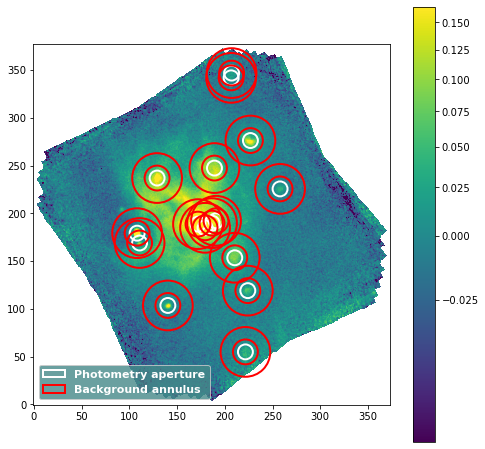

In [255]:
#now try photometry with local background subtraction
aperture2 =SkyCircularAperture(sourcecoords, r=6*u.arcsec) #define aperture
annulus_aperture_in = SkyCircularAnnulus(sourcecoords, r_in=6*u.arcsec, r_out=12*u.arcsec) #define annulus small
annulus_aperture_out = SkyCircularAnnulus(sourcecoords, r_in=10*u.arcsec, r_out=20*u.arcsec) #define annulus large

#convert to pixel coords for plotting
pix_aperture = aperture2.to_pixel(wcsmap)
pix_annulus_ap_in = annulus_aperture_in.to_pixel(wcsmap)
pix_annulus_ap_out = annulus_aperture_out.to_pixel(wcsmap)

#show figure with apertures overlayed
plt.figure(figsize=(8,8))
norm = simple_norm(data, 'sqrt', percent=99)
plt.imshow(data, norm=norm, interpolation='nearest',origin='lower')
plt.colorbar()
#plt.xlim(40, 140)
#plt.ylim(50, 125)

ap_patches = pix_aperture.plot(color='white', lw=2,
                           label='Photometry aperture')
ann_patches = pix_annulus_ap_out.plot(color='red', lw=2,
                                    label='Background annulus')
handles = (ap_patches[0], ann_patches[0])
plt.legend(loc='best', facecolor='#458989', labelcolor='white',
           handles=handles, prop={'weight': 'bold', 'size': 11})
plt.show()

In [256]:
'''
#now try photometry with local background subtraction
aperture2 =SkyCircularAperture(sourcecoords, r=6*u.arcsec) #define aperture
annulus_aperture = SkyCircularAnnulus(sourcecoords, r_in=10*u.arcsec, r_out=16*u.arcsec) #define annulus

#convert to pixel coords for plotting
pix_aperture = aperture2.to_pixel(wcsmap)
pix_annulus_aperture = annulus_aperture.to_pixel(wcsmap)


#show figure with apertures overlayed
plt.figure(figsize=(8,8))
norm = simple_norm(data, 'sqrt', percent=99)
plt.imshow(data, norm=norm, interpolation='nearest',origin='lower')
plt.colorbar()
#plt.xlim(40, 140)
#plt.ylim(50, 125)

ap_patches = pix_aperture.plot(color='white', lw=2,
                           label='Photometry aperture')
ann_patches = pix_annulus_aperture.plot(color='red', lw=2,
                                    label='Background annulus')
handles = (ap_patches[0], ann_patches[0])
plt.legend(loc='best', facecolor='#458989', labelcolor='white',
           handles=handles, prop={'weight': 'bold', 'size': 11})
plt.show()
'''

"\n#now try photometry with local background subtraction\naperture2 =SkyCircularAperture(sourcecoords, r=6*u.arcsec) #define aperture\nannulus_aperture = SkyCircularAnnulus(sourcecoords, r_in=10*u.arcsec, r_out=16*u.arcsec) #define annulus\n\n#convert to pixel coords for plotting\npix_aperture = aperture2.to_pixel(wcsmap)\npix_annulus_aperture = annulus_aperture.to_pixel(wcsmap)\n\n\n#show figure with apertures overlayed\nplt.figure(figsize=(8,8))\nnorm = simple_norm(data, 'sqrt', percent=99)\nplt.imshow(data, norm=norm, interpolation='nearest',origin='lower')\nplt.colorbar()\n#plt.xlim(40, 140)\n#plt.ylim(50, 125)\n\nap_patches = pix_aperture.plot(color='white', lw=2,\n                           label='Photometry aperture')\nann_patches = pix_annulus_aperture.plot(color='red', lw=2,\n                                    label='Background annulus')\nhandles = (ap_patches[0], ann_patches[0])\nplt.legend(loc='best', facecolor='#458989', labelcolor='white',\n           handles=handles, pro

In [257]:
'''
#now lets do robust statistics on the background annuli

#create lists to store information for later
bkg_median=[]
bkg_mean=[]
bkg_std=[]
appmasks=[]

#create mask array for the annuli
annulus_masks = pix_annulus_aperture.to_mask(method='exact')

#for each of the annuli loop through and calculate stats using sigma cliped stats
for mask in annulus_masks:
    annulus_data = mask.multiply(data_bkgsub)
    
    #this is a bit of debugging to handle if the mask array is the wrong shape
    if np.shape(mask.data)[0]==41:
        maskdata=mask.data[:-1,:]
    else:
        maskdata=mask.data
        
    #do statistics
    annulus_data_1d = annulus_data[maskdata > 0]
    meansc, median_sigclip, stdsc = sigma_clipped_stats(annulus_data_1d)
    bkg_median.append(median_sigclip)
    bkg_mean.append(meansc)
    bkg_std.append(stdsc)
    appmasks.append(mask.data)

#store values in numpy arrays
bkg_median = np.array(bkg_median)
bkg_mean = np.array(bkg_mean)
bkg_std = np.array(bkg_std)
'''

"\n#now lets do robust statistics on the background annuli\n\n#create lists to store information for later\nbkg_median=[]\nbkg_mean=[]\nbkg_std=[]\nappmasks=[]\n\n#create mask array for the annuli\nannulus_masks = pix_annulus_aperture.to_mask(method='exact')\n\n#for each of the annuli loop through and calculate stats using sigma cliped stats\nfor mask in annulus_masks:\n    annulus_data = mask.multiply(data_bkgsub)\n    \n    #this is a bit of debugging to handle if the mask array is the wrong shape\n    if np.shape(mask.data)[0]==41:\n        maskdata=mask.data[:-1,:]\n    else:\n        maskdata=mask.data\n        \n    #do statistics\n    annulus_data_1d = annulus_data[maskdata > 0]\n    meansc, median_sigclip, stdsc = sigma_clipped_stats(annulus_data_1d)\n    bkg_median.append(median_sigclip)\n    bkg_mean.append(meansc)\n    bkg_std.append(stdsc)\n    appmasks.append(mask.data)\n\n#store values in numpy arrays\nbkg_median = np.array(bkg_median)\nbkg_mean = np.array(bkg_mean)\nbkg_

In [258]:
#now lets do robust statistics on the background annuli

#create lists to store information for later
bkg_median=[]
bkg_mean=[]
bkg_std=[]
appmasks_in=[]
appmasks_out=[]

#create mask arrays for the annuli
annulus_masks_in = pix_annulus_ap_in.to_mask(method='exact')
annulus_masks_out = pix_annulus_ap_out.to_mask(method='exact')

#for each of the annuli loop through and calculate stats using sigma cliped stats
for mask in annulus_masks_in:
    annulus_data = mask.multiply(data_bkgsub)

    maskdata=mask.data
    
    #print(np.shape(annulus_data))
    #print(np.shape(maskdata))
    #print("\n")
        
    #do statistics
    annulus_data_1d = annulus_data[maskdata > 0]
    meansc, median_sigclip, stdsc = sigma_clipped_stats(annulus_data_1d)
    bkg_median.append(median_sigclip)
    bkg_mean.append(meansc)
    bkg_std.append(stdsc)
    appmasks.append(mask.data)

#store values in numpy arrays
bkg_median_in = np.array(bkg_median)
bkg_mean_in = np.array(bkg_mean)
bkg_std_in = np.array(bkg_std)

#create lists to store information for later
bkg_median=[]
bkg_mean=[]
bkg_std=[]

#for each of the annuli loop through and calculate stats using sigma cliped stats
for mask in annulus_masks_out:
    annulus_data = mask.multiply(data_bkgsub)
    
    maskdata=mask.data
        
    #do statistics
    annulus_data_1d = annulus_data[maskdata > 0]
    meansc, median_sigclip, stdsc = sigma_clipped_stats(annulus_data_1d)
    bkg_median.append(median_sigclip)
    bkg_mean.append(meansc)
    bkg_std.append(stdsc)
    appmasks.append(mask.data)

#store values in numpy arrays
bkg_median_out = np.array(bkg_median)
bkg_mean_out = np.array(bkg_mean)
bkg_std_out = np.array(bkg_std)

In [259]:
'''
#do aperture photometry
phot_table2 = aperture_photometry(data_bkgsub, aperture2,wcs=wcsmap,error=errormap,method='exact') #

#add columns for background information and also background subtracted apertures
phot_table2['ann_bkg_med'] = bkg_median
phot_table2['ann_bkg_mean'] = bkg_mean 
phot_table2['aper_sum_bkgsub_6as'] = (phot_table2['aperture_sum']/pix_aperture.area - phot_table2['ann_bkg_med'])* pix_aperture.area 
phot_table2['aper_sum_bkgsub_err_6as'] = phot_table2['aperture_sum_err'] # should this be modified by bkgsub in some way?
#not sure if the above is right for the error array...

#calculate sky noise for 6 pixel aperture
skynoise=np.sqrt(phot_table2['ann_bkg_med']*pix_aperture.area)
sna=np.array(skynoise)
masknan=np.isnan(sna)
sna[masknan]=0.0
skynoise=sna**2

#store per pix sky noise for later
phot_table2['skynoise_pix']=skynoise/pix_aperture.area

#shot noise from the source
sourcenoise=phot_table2['aper_sum_bkgsub_6as']

#thermal noise from camera (from error map)
thermalnoise=phot_table2['aperture_sum_err']

#compute total noise 
#totalnoise=np.sqrt(sourcenoise+thermalnoise+skynoise) #all noise sources
#totalnoise=np.sqrt(thermalnoise+skynoise) # no shot noise -> For some reason this seems to give more 'reasonable' values. Need to think about why this is a bit more...
totalnoise=np.sqrt((thermalnoise+skynoise)*(1+pix_aperture.area/pix_annulus_aperture.area)) #modified to account for pixel stats

#SNR calc for 6 pixel aperture
phot_table2['aper_snr_6as']=phot_table2['aper_sum_bkgsub_6as']/totalnoise

#display new table
phot_table2
'''

"\n#do aperture photometry\nphot_table2 = aperture_photometry(data_bkgsub, aperture2,wcs=wcsmap,error=errormap,method='exact') #\n\n#add columns for background information and also background subtracted apertures\nphot_table2['ann_bkg_med'] = bkg_median\nphot_table2['ann_bkg_mean'] = bkg_mean \nphot_table2['aper_sum_bkgsub_6as'] = (phot_table2['aperture_sum']/pix_aperture.area - phot_table2['ann_bkg_med'])* pix_aperture.area \nphot_table2['aper_sum_bkgsub_err_6as'] = phot_table2['aperture_sum_err'] # should this be modified by bkgsub in some way?\n#not sure if the above is right for the error array...\n\n#calculate sky noise for 6 pixel aperture\nskynoise=np.sqrt(phot_table2['ann_bkg_med']*pix_aperture.area)\nsna=np.array(skynoise)\nmasknan=np.isnan(sna)\nsna[masknan]=0.0\nskynoise=sna**2\n\n#store per pix sky noise for later\nphot_table2['skynoise_pix']=skynoise/pix_aperture.area\n\n#shot noise from the source\nsourcenoise=phot_table2['aper_sum_bkgsub_6as']\n\n#thermal noise from came

In [260]:
#do aperture photometry
phot_table2 = aperture_photometry(data_bkgsub, aperture2,wcs=wcsmap,error=errormap,method='exact') #

#add columns for background information and also background subtracted apertures
phot_table2['annsm_bkg_med'] = bkg_median_in
phot_table2['annsm_bkg_mean'] = bkg_mean_in 
phot_table2['annlg_bkg_med'] = bkg_median_out
phot_table2['annlg_bkg_mean'] = bkg_mean_out 

#move this to later
#phot_table2['aper_sum_bkgsub_6as'] = (phot_table2['aperture_sum']/pix_aperture.area - phot_table2['ann_bkg_med'])* pix_aperture.area 
#phot_table2['aper_sum_bkgsub_err_6as'] = phot_table2['aperture_sum_err'] # should this be modified by bkgsub in some way?
#not sure if the above is right for the error array...

#calculate sky noise for 6 pixel aperture using smaller annulus
skynoise_sap=np.sqrt(phot_table2['annsm_bkg_med']*pix_aperture.area)
sna=np.array(skynoise_sap)
masknan=np.isnan(sna)
sna[masknan]=0.0
skynoise_sap=sna**2

#store per pix sky noise for later
phot_table2['skynoise_pix_sm']=skynoise_sap/pix_aperture.area

#calculate sky noise for 6 pixel aperture using larger annulus
skynoise_lap=np.sqrt(phot_table2['annlg_bkg_med']*pix_aperture.area)
sna=np.array(skynoise_lap)
masknan=np.isnan(sna)
sna[masknan]=0.0
skynoise_lap=sna**2

#store per pix sky noise for later
phot_table2['skynoise_pix_lg']=skynoise_lap/pix_aperture.area


#do the SNR calcs later...
#shot noise from the source
#sourcenoise=phot_table2['aper_sum_bkgsub_6as']

#thermal noise from camera (from error map)
#thermalnoise=phot_table2['aperture_sum_err']

#compute total noise 
#totalnoise=np.sqrt(sourcenoise+thermalnoise+skynoise) #all noise sources
#totalnoise=np.sqrt(thermalnoise+skynoise) # no shot noise -> For some reason this seems to give more 'reasonable' values. Need to think about why this is a bit more...
#totalnoise=np.sqrt((thermalnoise+skynoise)*(1+pix_aperture.area/pix_annulus_aperture.area)) #modified to account for pixel stats

#SNR calc for 6 pixel aperture
#phot_table2['aper_snr_6as']=phot_table2['aper_sum_bkgsub_6as']/totalnoise

#display new table
phot_table2

<ipython-input-260-6428622f4761>:16: RuntimeWarning: invalid value encountered in sqrt
  skynoise_sap=np.sqrt(phot_table2['annsm_bkg_med']*pix_aperture.area)
<ipython-input-260-6428622f4761>:26: RuntimeWarning: invalid value encountered in sqrt
  skynoise_lap=np.sqrt(phot_table2['annlg_bkg_med']*pix_aperture.area)


id,xcenter,ycenter,sky_center,aperture_sum,aperture_sum_err,annsm_bkg_med,annsm_bkg_mean,annlg_bkg_med,annlg_bkg_mean,skynoise_pix_sm,skynoise_pix_lg
,pix,pix,"deg,deg",,,,,,,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64
1,221.6165509442321,54.936734276325524,"266.13978020429977,-29.497235056387865",5.431690665938099,0.23724483785345124,0.006327654062107422,0.0073159680285732635,0.0011671741970363816,0.0022175542151628767,0.006327654062107423,0.0011671741970363816
2,140.39632877635597,103.56905733876239,"266.15968607285254,-29.48685944010572",6.197913980114574,0.14170854514251846,0.0009262225750371374,0.0013975662691152657,-0.0018230954921781535,-0.0023265558230606553,0.0009262225750371375,0.0
3,224.12542347557059,119.09459214212097,"266.13916604130884,-29.483548024257136",4.592690219246912,0.14147678643516473,0.0021993240266344753,0.0024148830893552134,-0.0007803685357554966,-0.0010952795704609211,0.0021993240266344753,0.0
4,210.44909590871453,153.5123802791827,"266.14251787942567,-29.476205664300405",9.44150690321998,0.13927567282333397,0.006828776981115392,0.008186344909079407,-0.0029900905965743515,-0.003605064680041729,0.006828776981115391,0.0
5,110.78776697204559,168.97998378308105,"266.1669394638323,-29.47290411044649",1.4751725378234843,0.1415682201035204,0.0013525770964115495,0.000995458073699115,-0.001214932305327534,-0.000577970512767075,0.0013525770964115497,0.0
6,108.21842570704759,179.27225181735713,"266.1675685765994,-29.47070832144944",14.722418939722656,0.14210675416717708,-0.010821880842887384,-0.012142841273107031,-0.00622964136888742,-0.00509217237691592,0.0,0.0
7,257.91067631729044,225.64826742758126,"266.13088940205085,-29.460815964580334",3.072444432883658,0.14254687632845917,-0.0005482160435039847,-0.0008922389088511675,-0.0014437017914235243,-0.0017885123109994418,0.0,0.0
8,129.11526870018383,236.99936361760746,"266.1624458880217,-29.45839397536969",15.257543276975493,0.14207983498659413,0.00931902710062329,0.009186267772091425,0.0023924379886731376,0.0006443396955334706,0.00931902710062329,0.0023924379886731376


In [261]:
#fix id keyword in tbl2 so these can be merged with the phot table results
try:
    tbl2.rename_column('label', 'id')
except:
    print('Do nothing because keyword is already changed.')

In [262]:
'''
#merge the two photometry tables
merged_table = join(phot_table, phot_table2, keys='id')

#merge the segmentation map table with the combined phot table
merged_table_2 = join(tbl2,merged_table, keys='id')

#drop repeat columns
merged_table_2.remove_columns(['xcenter_1','ycenter_1','xcenter_2','ycenter_2','sky_center_1','sky_center_2','aperture_sum','aperture_sum_err'])

#rename some columns to avoid possible confusion
merged_table_2.rename_column('aperture_sum_0', 'aperture_sum_2as')
merged_table_2.rename_column('aperture_sum_err_0', 'aperture_sum_err_2as')
merged_table_2.rename_column('aperture_sum_1', 'aperture_sum_4as')
merged_table_2.rename_column('aperture_sum_err_1', 'aperture_sum_err_4as')
merged_table_2.rename_column('aperture_sum_2', 'aperture_sum_6as')
merged_table_2.rename_column('aperture_sum_err_2', 'aperture_sum_err_6as')
merged_table_2.rename_column('aperture_sum_3', 'aperture_sum_8as')
merged_table_2.rename_column('aperture_sum_err_3', 'aperture_sum_err_8as')
merged_table_2.rename_column('aperture_sum_4', 'aperture_sum_10as')
merged_table_2.rename_column('aperture_sum_err_4', 'aperture_sum_err_10as')


#compute area for the different size apertures 
ap2area=pix_aperture.area*(2./6.)**2
ap4area=pix_aperture.area*(4./6.)**2
#ap6area=pix_aperture.area*(6./6.)**2
ap8area=pix_aperture.area*(8./6.)**2
ap10area=pix_aperture.area*(10./6.)**2


#calculate local bkg subtracted photometry for the other apertures 
merged_table_2['aper_sum_bkgsub_2as']=(merged_table_2['aperture_sum_2as']/ap2area-merged_table_2['ann_bkg_med'])*ap2area
merged_table_2['aper_sum_bkgsub_4as']=(merged_table_2['aperture_sum_4as']/ap4area-merged_table_2['ann_bkg_med'])*ap4area
#merged_table_2['aper_sum_bkgsub_6as']=(merged_table_2['aperture_sum_6as']/ap6area-merged_table_2['ann_bkg_med'])*ap6area
merged_table_2['aper_sum_bkgsub_8as']=(merged_table_2['aperture_sum_8as']/ap8area-merged_table_2['ann_bkg_med'])*ap8area
merged_table_2['aper_sum_bkgsub_10as']=(merged_table_2['aperture_sum_10as']/ap10area-merged_table_2['ann_bkg_med'])*ap10area

#calculate snr for each aperture
merged_table_2['aper_snr_2as']=merged_table_2['aper_sum_bkgsub_2as']/np.sqrt((merged_table_2['aperture_sum_err_2as']+merged_table_2['skynoise_pix']*ap2area)*(1+ap2area/pix_annulus_aperture.area))
merged_table_2['aper_snr_4as']=merged_table_2['aper_sum_bkgsub_4as']/np.sqrt((merged_table_2['aperture_sum_err_4as']+merged_table_2['skynoise_pix']*ap4area)*(1+ap4area/pix_annulus_aperture.area))
#merged_table_2['aper_snr_6as']=merged_table_2['aper_sum_bkgsub_6as']/np.sqrt((merged_table_2['aperture_sum_err_6as']+merged_table_2['skynoise_pix']*ap6area)*(1+ap6area/pix_annulus_aperture.area))
merged_table_2['aper_snr_8as']=merged_table_2['aper_sum_bkgsub_8as']/np.sqrt((merged_table_2['aperture_sum_err_8as']+merged_table_2['skynoise_pix']*ap8area)*(1+ap8area/pix_annulus_aperture.area))
merged_table_2['aper_snr_10as']=merged_table_2['aper_sum_bkgsub_10as']/np.sqrt((merged_table_2['aperture_sum_err_10as']+merged_table_2['skynoise_pix']*ap10area)*(1+ap10area/pix_annulus_aperture.area))

#calculate max snr for all apertures
snr_values=np.array(merged_table_2['aper_snr_2as','aper_snr_4as','aper_snr_6as','aper_snr_8as','aper_snr_10as'])
snr_values.dtype=np.float
snr_values=np.reshape(snr_values, (-1,5))
maxsnr=np.nanmax(snr_values,axis=1)
merged_table_2['aper_snr_max']=maxsnr

#add additonal information for wavelength and which field 
merged_table_2['Field']='C7'+field
merged_table_2['wv']=wavelength

#display table
merged_table_2
'''

"\n#merge the two photometry tables\nmerged_table = join(phot_table, phot_table2, keys='id')\n\n#merge the segmentation map table with the combined phot table\nmerged_table_2 = join(tbl2,merged_table, keys='id')\n\n#drop repeat columns\nmerged_table_2.remove_columns(['xcenter_1','ycenter_1','xcenter_2','ycenter_2','sky_center_1','sky_center_2','aperture_sum','aperture_sum_err'])\n\n#rename some columns to avoid possible confusion\nmerged_table_2.rename_column('aperture_sum_0', 'aperture_sum_2as')\nmerged_table_2.rename_column('aperture_sum_err_0', 'aperture_sum_err_2as')\nmerged_table_2.rename_column('aperture_sum_1', 'aperture_sum_4as')\nmerged_table_2.rename_column('aperture_sum_err_1', 'aperture_sum_err_4as')\nmerged_table_2.rename_column('aperture_sum_2', 'aperture_sum_6as')\nmerged_table_2.rename_column('aperture_sum_err_2', 'aperture_sum_err_6as')\nmerged_table_2.rename_column('aperture_sum_3', 'aperture_sum_8as')\nmerged_table_2.rename_column('aperture_sum_err_3', 'aperture_sum_

In [263]:
#merge the two photometry tables
merged_table = join(phot_table, phot_table2, keys='id')

#merge the segmentation map table with the combined phot table
merged_table_2 = join(tbl2,merged_table, keys='id')

#drop repeat columns
merged_table_2.remove_columns(['xcenter_1','ycenter_1','xcenter_2','ycenter_2','sky_center_1','sky_center_2','aperture_sum','aperture_sum_err'])

#rename some columns to avoid possible confusion
merged_table_2.rename_column('aperture_sum_0', 'aperture_sum_2as')
merged_table_2.rename_column('aperture_sum_err_0', 'aperture_sum_err_2as')
merged_table_2.rename_column('aperture_sum_1', 'aperture_sum_4as')
merged_table_2.rename_column('aperture_sum_err_1', 'aperture_sum_err_4as')
merged_table_2.rename_column('aperture_sum_2', 'aperture_sum_6as')
merged_table_2.rename_column('aperture_sum_err_2', 'aperture_sum_err_6as')
merged_table_2.rename_column('aperture_sum_3', 'aperture_sum_8as')
merged_table_2.rename_column('aperture_sum_err_3', 'aperture_sum_err_8as')
merged_table_2.rename_column('aperture_sum_4', 'aperture_sum_10as')
merged_table_2.rename_column('aperture_sum_err_4', 'aperture_sum_err_10as')


#compute area for the different size apertures 
ap2area=pix_aperture.area*(2./6.)**2
ap4area=pix_aperture.area*(4./6.)**2
ap6area=pix_aperture.area*(6./6.)**2
ap8area=pix_aperture.area*(8./6.)**2
ap10area=pix_aperture.area*(10./6.)**2


#calculate local bkg subtracted photometry for the other apertures 
merged_table_2['aper_sum_bkgsub_2as']=(merged_table_2['aperture_sum_2as']/ap2area-merged_table_2['annsm_bkg_med'])*ap2area
merged_table_2['aper_sum_bkgsub_4as']=(merged_table_2['aperture_sum_4as']/ap4area-merged_table_2['annsm_bkg_med'])*ap4area
merged_table_2['aper_sum_bkgsub_6as']=(merged_table_2['aperture_sum_6as']/ap6area-merged_table_2['annlg_bkg_med'])*ap6area
merged_table_2['aper_sum_bkgsub_8as']=(merged_table_2['aperture_sum_8as']/ap8area-merged_table_2['annlg_bkg_med'])*ap8area
merged_table_2['aper_sum_bkgsub_10as']=(merged_table_2['aperture_sum_10as']/ap10area-merged_table_2['annlg_bkg_med'])*ap10area

#calculate snr for each aperture
merged_table_2['aper_snr_2as']=merged_table_2['aper_sum_bkgsub_2as']/np.sqrt((merged_table_2['aperture_sum_err_2as']+merged_table_2['skynoise_pix_sm']*ap2area)*(1+ap2area/pix_annulus_ap_in.area))
merged_table_2['aper_snr_4as']=merged_table_2['aper_sum_bkgsub_4as']/np.sqrt((merged_table_2['aperture_sum_err_4as']+merged_table_2['skynoise_pix_sm']*ap4area)*(1+ap4area/pix_annulus_ap_in.area))
merged_table_2['aper_snr_6as']=merged_table_2['aper_sum_bkgsub_6as']/np.sqrt((merged_table_2['aperture_sum_err_6as']+merged_table_2['skynoise_pix_lg']*ap6area)*(1+ap6area/pix_annulus_ap_out.area))
merged_table_2['aper_snr_8as']=merged_table_2['aper_sum_bkgsub_8as']/np.sqrt((merged_table_2['aperture_sum_err_8as']+merged_table_2['skynoise_pix_lg']*ap8area)*(1+ap8area/pix_annulus_ap_out.area))
merged_table_2['aper_snr_10as']=merged_table_2['aper_sum_bkgsub_10as']/np.sqrt((merged_table_2['aperture_sum_err_10as']+merged_table_2['skynoise_pix_lg']*ap10area)*(1+ap10area/pix_annulus_ap_out.area))

#calculate max snr for all apertures
snr_values=np.array(merged_table_2['aper_snr_2as','aper_snr_4as','aper_snr_6as','aper_snr_8as','aper_snr_10as'])
snr_values.dtype=np.float
snr_values=np.reshape(snr_values, (-1,5))
maxsnr=np.nanmax(snr_values,axis=1)
merged_table_2['aper_snr_max']=maxsnr

#add additonal information for wavelength and which field 
merged_table_2['Field']='C7'+field
merged_table_2['wv']=wavelength

#display table
merged_table_2

id,xcentroid,ycentroid,sky_centroid,background_centroid,background_mean,background_sum,area,semimajor_sigma,semiminor_sigma,orientation,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr,segbkg_mean_sc,segbkg_median_sc,segbkg_std_sc,segmentSNR,aperture_sum_2as,aperture_sum_err_2as,aperture_sum_4as,aperture_sum_err_4as,aperture_sum_6as,aperture_sum_err_6as,aperture_sum_8as,aperture_sum_err_8as,aperture_sum_10as,aperture_sum_err_10as,annsm_bkg_med,annsm_bkg_mean,annlg_bkg_med,annlg_bkg_mean,skynoise_pix_sm,skynoise_pix_lg,aper_sum_bkgsub_2as,aper_sum_bkgsub_4as,aper_sum_bkgsub_6as,aper_sum_bkgsub_8as,aper_sum_bkgsub_10as,aper_snr_2as,aper_snr_4as,aper_snr_6as,aper_snr_8as,aper_snr_10as,aper_snr_max,Field,wv
,,,"deg,deg",,,,pix2,pix,pix,deg,1 / pix2,1 / pix2,1 / pix2,,,,pix,,,pix,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str8,float64
1,221.6165509442812,54.93673427647289,"266.13978020429977,-29.497235056387865",-0.018137281707807006,-0.0030242428105773313,-0.26613336733080517,88.0,2.904774948891367,2.345999014268467,70.39949720347359,0.17458570794927664,-0.03993254084777956,0.12562532992401015,0.589682199130736,0.19236462185690562,1.2381825104036281,6.217221926300213,12.956505038381742,0.7600847407661554,3.0208522911502214,3.3116104391077914,0.1631745,-0.002875852051494358,-0.003017922672943979,0.000985570327143869,8.198097973428014,0.8545315994809511,0.08253965426531067,3.1783921954499257,0.1604363051243773,5.431690665938099,0.23724483785345124,7.464944052518822,0.31998547845130265,9.165760657321208,0.412625403320962,0.006327654062107422,0.0073159680285732635,0.0011671741970363816,0.0022175542151628767,0.006327654062107423,0.0011671741970363816,0.7197191050972312,2.6391422179150466,5.207887820516196,7.067072327324327,8.544086086704809,1.515946688914393,2.9445040053311056,7.247357543210228,7.572345832871599,7.275669959938427,7.572345832871599,C7Field2,25.2
2,140.39632877627477,103.5690573387696,"266.15968607285254,-29.48685944010572",0.0066686772283519906,-0.006928078447392761,-0.5473181973440281,79.0,2.033049833925688,1.9190565861479376,-38.5706838284798,0.2534427681408011,0.02885400318712459,0.26002929526072316,0.33014585933359075,0.05607007062765257,1.0594006704130416,4.655184958954311,6.9389817044592474,0.18780157774286113,2.0965554898477974,4.956756218359404,0.09096325,-0.007140446756318711,-0.007223267204584543,0.0013142718216045581,16.434805594075648,2.814625243623711,0.04725918661190095,4.993895880050231,0.09448086648647637,6.197913980114574,0.14170854514251846,6.9668797023233475,0.18895276403955943,7.306553554307429,0.236162739603919,0.0009262225750371374,0.0013975662691152657,-0.0018230954921781535,-0.0023265558230606553,0.0009262225750371375,0.0,2.794891804584586,4.914962123893731,6.547488156498289,7.588344904783285,8.277592933151082,10.603625158190011,11.014844055794342,16.43492363642551,15.848215685915413,14.751256267783601,16.43492363642551,C7Field2,25.2
3,224.12542347564218,119.09459214217581,"266.13916604130884,-29.483548024257136",0.07771152310059598,0.00017051130418118597,0.015516528680487923,91.0,2.884835816316731,2.182639398499454,36.07307174091866,0.15127686798321077,-0.08542967482519895,0.17879394200558069,0.6538889827557146,0.24340949105166743,1.321718932728893,6.023506416632345,6.294265529533203,0.25694853651533134,2.260977053376203,3.4995267448876652,0.09742679,-3.671359754506809e-05,-0.00020849505859099163,0.0019709614166440203,11.211665360576927,1.186000167650302,0.04712321423329318,3.266922400123304,0.09428768369159893,4.59

In [264]:
#write out the resulting table to file
ascii.write(merged_table_2, field+'_25um_cat.dat', overwrite=True)

In [265]:
#add simple quality cuts to saved sources
snrcut=merged_table_2['aper_snr_max']>=3.0 #max snr in all computed apertures must be gtreq to 3.0
#fwhmcut=merged_table_2['fwhm']>=2.5*u.pix #fwhm measures must be greater than 2.5 pixels (~1.9")
#keepconditions=(snrcut&fwhmcut) #conditions to keep a source
#mtcut=merged_table_2[keepconditions] #apply conditions
mtcut=merged_table_2[snrcut] #apply only snr cut

#display new table with simple quality cuts
mtcut

id,xcentroid,ycentroid,sky_centroid,background_centroid,background_mean,background_sum,area,semimajor_sigma,semiminor_sigma,orientation,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr,segbkg_mean_sc,segbkg_median_sc,segbkg_std_sc,segmentSNR,aperture_sum_2as,aperture_sum_err_2as,aperture_sum_4as,aperture_sum_err_4as,aperture_sum_6as,aperture_sum_err_6as,aperture_sum_8as,aperture_sum_err_8as,aperture_sum_10as,aperture_sum_err_10as,annsm_bkg_med,annsm_bkg_mean,annlg_bkg_med,annlg_bkg_mean,skynoise_pix_sm,skynoise_pix_lg,aper_sum_bkgsub_2as,aper_sum_bkgsub_4as,aper_sum_bkgsub_6as,aper_sum_bkgsub_8as,aper_sum_bkgsub_10as,aper_snr_2as,aper_snr_4as,aper_snr_6as,aper_snr_8as,aper_snr_10as,aper_snr_max,Field,wv
,,,"deg,deg",,,,pix2,pix,pix,deg,1 / pix2,1 / pix2,1 / pix2,,,,pix,,,pix,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str8,float64
1,221.6165509442812,54.93673427647289,"266.13978020429977,-29.497235056387865",-0.018137281707807006,-0.0030242428105773313,-0.26613336733080517,88.0,2.904774948891367,2.345999014268467,70.39949720347359,0.17458570794927664,-0.03993254084777956,0.12562532992401015,0.589682199130736,0.19236462185690562,1.2381825104036281,6.217221926300213,12.956505038381742,0.7600847407661554,3.0208522911502214,3.3116104391077914,0.1631745,-0.002875852051494358,-0.003017922672943979,0.000985570327143869,8.198097973428014,0.8545315994809511,0.08253965426531067,3.1783921954499257,0.1604363051243773,5.431690665938099,0.23724483785345124,7.464944052518822,0.31998547845130265,9.165760657321208,0.412625403320962,0.006327654062107422,0.0073159680285732635,0.0011671741970363816,0.0022175542151628767,0.006327654062107423,0.0011671741970363816,0.7197191050972312,2.6391422179150466,5.207887820516196,7.067072327324327,8.544086086704809,1.515946688914393,2.9445040053311056,7.247357543210228,7.572345832871599,7.275669959938427,7.572345832871599,C7Field2,25.2
2,140.39632877627477,103.5690573387696,"266.15968607285254,-29.48685944010572",0.0066686772283519906,-0.006928078447392761,-0.5473181973440281,79.0,2.033049833925688,1.9190565861479376,-38.5706838284798,0.2534427681408011,0.02885400318712459,0.26002929526072316,0.33014585933359075,0.05607007062765257,1.0594006704130416,4.655184958954311,6.9389817044592474,0.18780157774286113,2.0965554898477974,4.956756218359404,0.09096325,-0.007140446756318711,-0.007223267204584543,0.0013142718216045581,16.434805594075648,2.814625243623711,0.04725918661190095,4.993895880050231,0.09448086648647637,6.197913980114574,0.14170854514251846,6.9668797023233475,0.18895276403955943,7.306553554307429,0.236162739603919,0.0009262225750371374,0.0013975662691152657,-0.0018230954921781535,-0.0023265558230606553,0.0009262225750371375,0.0,2.794891804584586,4.914962123893731,6.547488156498289,7.588344904783285,8.277592933151082,10.603625158190011,11.014844055794342,16.43492363642551,15.848215685915413,14.751256267783601,16.43492363642551,C7Field2,25.2
3,224.12542347564218,119.09459214217581,"266.13916604130884,-29.483548024257136",0.07771152310059598,0.00017051130418118597,0.015516528680487923,91.0,2.884835816316731,2.182639398499454,36.07307174091866,0.15127686798321077,-0.08542967482519895,0.17879394200558069,0.6538889827557146,0.24340949105166743,1.321718932728893,6.023506416632345,6.294265529533203,0.25694853651533134,2.260977053376203,3.4995267448876652,0.09742679,-3.671359754506809e-05,-0.00020849505859099163,0.0019709614166440203,11.211665360576927,1.186000167650302,0.04712321423329318,3.266922400123304,0.09428768369159893,4.59

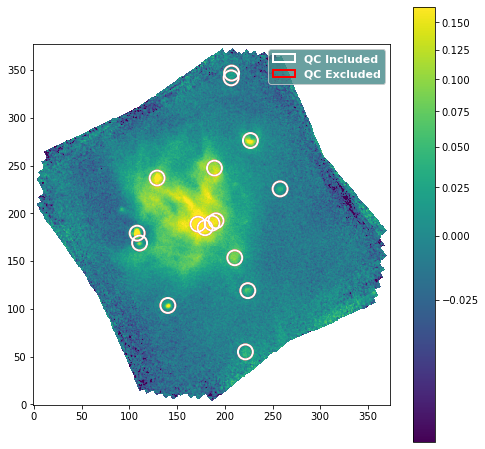

In [266]:
#now let's examine which sources didn't pass the cuts - overplot on the image to see if it looks first order reasonable

#get source coordinates for the snr cut table
cutsc=mtcut['sky_centroid'] 

#Compare which sources are included/excluded
source_aperture =SkyCircularAperture(cutsc, r=6*u.arcsec)

#convert to pixel coords for plotting
pix_aperture_source = source_aperture.to_pixel(wcsmap)


#show figure with apertures overlayed
plt.figure(figsize=(8,8))
norm = simple_norm(data, 'sqrt', percent=99)
plt.imshow(data, norm=norm, interpolation='nearest',origin='lower')
plt.colorbar()
#plt.xlim(40, 140)
#plt.ylim(50, 125)


ap_patches = pix_aperture.plot(color='red', lw=2,
                           label='QC Excluded')
ap_patches_new = pix_aperture_source.plot(color='white', lw=2,
                           label='QC Included')

handles = (ap_patches_new[0],ap_patches[0])
plt.legend(loc='best', facecolor='#458989', labelcolor='white',
          handles=handles, prop={'weight': 'bold', 'size': 11})
plt.show()

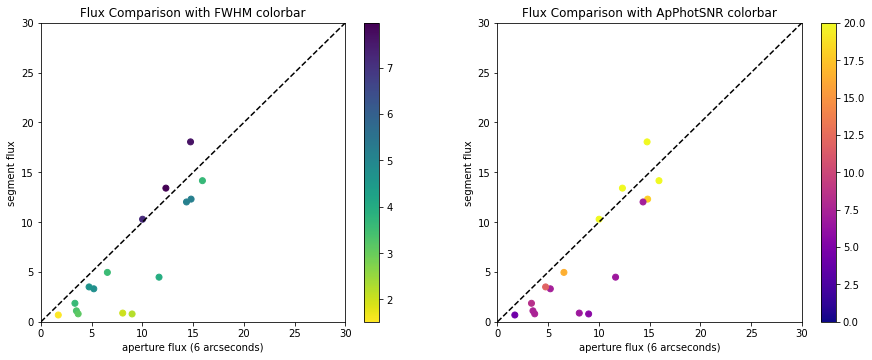

In [267]:
#a few diagnostic plots to examine segment and aperture fluxes
fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(15,5.5))

ax1.set_title('Flux Comparison with FWHM colorbar')
p1=ax1.scatter(mtcut['aper_sum_bkgsub_6as'],mtcut['segment_flux'],c=mtcut['fwhm']*0.768, cmap='viridis_r')
fig.colorbar(p1, ax=ax1)
ax1.plot([0,30],[0,30],'k--')
ax1.set_xlabel('aperture flux (6 arcseconds)')
ax1.set_ylabel('segment flux')
ax1.set_xlim(0,30)
ax1.set_ylim(0,30)

ax2.set_title('Flux Comparison with ApPhotSNR colorbar')
p2=ax2.scatter(mtcut['aper_sum_bkgsub_6as'],mtcut['segment_flux'],c=mtcut['aper_snr_6as'], cmap='plasma',vmin=0,vmax=20)
fig.colorbar(p2, ax=ax2)
ax2.plot([0,30],[0,30],'k--')
ax2.set_xlabel('aperture flux (6 arcseconds)')
ax2.set_ylabel('segment flux')
ax2.set_xlim(0,30)
ax2.set_ylim(0,30)


plt.show()

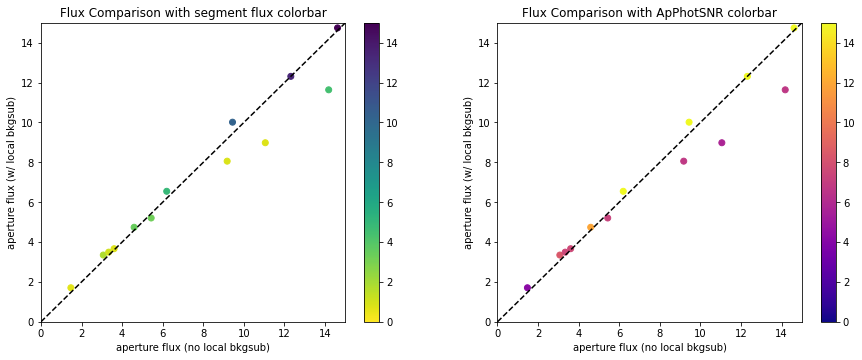

In [268]:
#a few diagnostic plots to examine background contributions to aperture flux
fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(15,5.5))

ax1.set_title('Flux Comparison with segment flux colorbar')
p1=ax1.scatter(mtcut['aperture_sum_6as'],mtcut['aper_sum_bkgsub_6as'],c=mtcut['segment_flux'], cmap='viridis_r',vmin=0,vmax=15)
fig.colorbar(p1, ax=ax1)
ax1.plot([0,30],[0,30],'k--')
ax1.set_xlabel('aperture flux (no local bkgsub)')
ax1.set_ylabel('aperture flux (w/ local bkgsub)')
ax1.set_xlim(0,15)
ax1.set_ylim(0,15)

ax2.set_title('Flux Comparison with ApPhotSNR colorbar')
p2=ax2.scatter(mtcut['aperture_sum_6as'],mtcut['aper_sum_bkgsub_6as'],c=mtcut['aper_snr_6as'], cmap='plasma',vmin=0,vmax=15)
fig.colorbar(p2, ax=ax2)
ax2.plot([0,30],[0,30],'k--')
ax2.set_xlabel('aperture flux (no local bkgsub)')
ax2.set_ylabel('aperture flux (w/ local bkgsub)')
ax2.set_xlim(0,15)
ax2.set_ylim(0,15)


plt.show()

In [269]:
#write out the resulting table to file
ascii.write(mtcut, field+'_25um_cat_qcuts.dat', overwrite=True)